# Sex differences in functional cortical organization (Serio et al.)

## Microstructural Data
- also supplementary check for field bias in t1w/t2w vs MPC gradient

## Load packages

In [2]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
import pingouin as pg
import pickle

# Computing / Analyses
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
from statsmodels.stats.multitest import fdrcorrection # does not yield exactly the same FDR correction as R but the same up to 14th decimal place so good enough

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [3]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'
resdir_suppl = '/data/p_02667/sex_diff_gradients/results/suppl/'

## Import functions

In [4]:
%run p1_myfunctions.ipynb

# Data 

## Descriptive HCP

### Retrieving the cleaned demographics dataframe (ready for analysis)

In [11]:
HCP_demographics_cleaned = pd.read_csv(resdir_hcp+'demographics_cleaned.csv')

In [12]:
HCP_demographics_cleaned

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used,Unnamed: 201,Unnamed: 202,Unnamed: 203,TwinStatus,TwinStatus_num,Family_ID_num,global_ct
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,118,2.583466
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,0.0,2.0,1.0,NaN,NaN,NaN,MZ,0,151,2.682427
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,1.0,2.0,4.0,NaN,NaN,NaN,MZ,0,39,2.534514
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,DZ,1,8,2.623609
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,0.0,2.0,5.0,NaN,NaN,NaN,MZ,0,1,2.542655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,992673,S900,Q12,F,31-35,True,1,2,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,346,2.582893
1010,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,0.0,3.0,2.0,NaN,NaN,NaN,sibling,2,277,2.616927
1011,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,347,2.635552
1012,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,1.0,2.0,5.0,NaN,NaN,NaN,sibling,2,202,2.677629


## Microstructural data 

MPC-fc-schaefer400.mat file taken from /data/pt_02319/schaare/data/HCP_fromSofie/ - contains connectivity matrices for:

- MPCnx : 1206, 400, 400  # MPC
- matrix_hcp400z : 1206, 400, 400  # fc z-scored

In [13]:
scipy.io.whosmat(datadir + 'HCP_microstructure/MPC-fc-schaefer400.mat')

[('MPCnx', (1206, 400, 400), 'double'),
 ('matrix_hcp400z', (1206, 400, 400), 'double')]

In [14]:
# taking the MPC matrices from the mat file
MPC_matrices = scipy.io.loadmat(datadir + 'HCP_microstructure/MPC-fc-schaefer400.mat')['MPCnx']

In [15]:
MPC_matrices.shape

(1206, 400, 400)

In [16]:
mean_MPC_matrix = sum(MPC_matrices)/len(MPC_matrices)

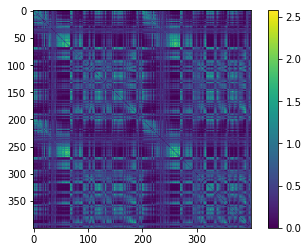

In [17]:
plt.imshow(mean_MPC_matrix)
plt.colorbar()
plt.show()

### Remove subjects with missing MPC matrices from structural analysis -> obtain a list of subjects with MPC matrices

#### check whether there are MPC matrices missing for some subjects

Checking for NaNs -> none

In [18]:
np.argwhere(np.isnan(MPC_matrices))

array([], shape=(0, 3), dtype=int64)

Checking for matrices that have a sum of 0 (meaning only zeroes) -> there are 113

In [19]:
indices_noMPC = []

for i in range(len(MPC_matrices)):
    if np.sum(MPC_matrices[i]) == 0.0:
        indices_noMPC.append(i)        

In [20]:
len(indices_noMPC)

113

In [21]:
indices_noMPC

[0,
 7,
 10,
 26,
 35,
 40,
 44,
 50,
 89,
 115,
 124,
 134,
 180,
 182,
 184,
 196,
 203,
 204,
 227,
 232,
 264,
 272,
 292,
 317,
 345,
 413,
 431,
 453,
 462,
 472,
 479,
 483,
 488,
 506,
 514,
 522,
 533,
 542,
 556,
 567,
 581,
 586,
 596,
 606,
 608,
 612,
 620,
 630,
 633,
 653,
 692,
 708,
 710,
 721,
 722,
 737,
 739,
 749,
 750,
 769,
 771,
 785,
 790,
 797,
 811,
 817,
 824,
 844,
 852,
 854,
 871,
 878,
 881,
 887,
 889,
 929,
 938,
 939,
 940,
 949,
 979,
 982,
 990,
 993,
 998,
 1013,
 1017,
 1019,
 1023,
 1025,
 1026,
 1032,
 1043,
 1051,
 1055,
 1068,
 1075,
 1080,
 1082,
 1094,
 1103,
 1114,
 1119,
 1122,
 1128,
 1154,
 1155,
 1158,
 1169,
 1172,
 1176,
 1180,
 1189]

#### Deleting the subjects that do not have MPC matrices

In [22]:
MPC_matrices = np.delete(MPC_matrices, indices_noMPC, axis=0)
MPC_matrices.shape

(1093, 400, 400)

#### Making a new subject lists for subjects that have MPC data (as well as fc data)

Retrieving one of the original (restricted) demographics dataframe because we need it to be able to index out from this original subject list (correct order) the subjects that do not have MPC data

In [23]:
restricted_data = pd.read_csv(datadir+'RESTRICTED_wanb_9_29_2020_2_14_36.csv')
print(f'Total Sample: N = {len(restricted_data)}')

Total Sample: N = 1206


Creating a subjet list for MPC by removing from the original subject list the subjects that do not have MPC data 

In [24]:
HCP_sub_list_MPC = np.array(restricted_data.Subject)

HCP_sub_list_MPC = np.delete(HCP_sub_list_MPC, indices_noMPC, axis=0)

In [28]:
len(HCP_sub_list_MPC)

1093

Exporting MPC subject list

In [25]:
np.savetxt(datadir+'HCP_sub_list_MPC.csv', 
           HCP_sub_list_MPC,
           delimiter =",", 
           fmt ='% s')

Exporting MPC matrices as mat file

In [26]:
mdict = {'MPC_matrices': MPC_matrices, 'HCP_sub_list_MPC': HCP_sub_list_MPC}

scipy.io.savemat(datadir+'HCP_microstructure/MPC_matrices_no_missing.mat', mdict)

#
#
#
#
# Supplement: Check field bias T1w/T2w (MPI) and MPC

## Making subset demographics dataframes for males and females

In [42]:
HCP_demographics_cleaned_withMPC_M = HCP_demographics_cleaned_withMPC[HCP_demographics_cleaned_withMPC["Gender"] == 'M']
HCP_demographics_cleaned_withMPC_F = HCP_demographics_cleaned_withMPC[HCP_demographics_cleaned_withMPC["Gender"] == 'F']

## BMI data

### Checking for NaNs in BMI data

In [43]:
np.argwhere(np.isnan(np.array(HCP_demographics_cleaned_withMPC.BMI)))

array([[460]])

#### Same for subset M & F

In [46]:
np.argwhere(np.isnan(np.array(HCP_demographics_cleaned_withMPC_M.BMI)))

array([], shape=(0, 1), dtype=int64)

In [47]:
np.argwhere(np.isnan(np.array(HCP_demographics_cleaned_withMPC_F.BMI)))

array([[254]])

### Cleaning BMI data (and removing corresponding subject's MPC G1 values)

In [48]:
HCP_BMI_rm_faulty = np.delete(np.array(HCP_demographics_cleaned_withMPC.BMI), [460], axis=0)
HCP_array_aligned_mpc_G1_rm_faulty_BMI = np.delete(HCP_array_aligned_mpc_G1, [460], axis=0)

In [49]:
HCP_BMI_rm_faulty_F = np.delete(np.array(HCP_demographics_cleaned_withMPC_F.BMI), [254], axis=0)
HCP_array_aligned_mpc_G1_rm_faulty_BMI_F = np.delete(HCP_array_aligned_mpc_G1_F, [254], axis=0)

## Microstructural intensity profile data -> mean MPI (should have bias according to Glasser et al. 2022)

### Downloading data

In [50]:
scipy.io.whosmat(datadir + 'HCP_microstructure/MPC_layers.mat')

[('MPC_layers', (1206, 12, 400), 'double')]

In [51]:
# taking the MPC matrices from the mat file
MPI_matrices = scipy.io.loadmat(datadir + 'HCP_microstructure/MPC_layers.mat')['MPC_layers']

In [52]:
MPI_matrices.shape

(1206, 12, 400)

### Computing mean MPI across layers

In [53]:
mean_MPI = []

# loop over subjects
for i in range(len(MPI_matrices)):
    
    # will contain the mean MPI for each parcel for 1 subject
    temp_mean_sub = []
    
    # loop over parcels
    for j in range(400):
        
        # take the mean of the 12 layers
        temp_mean_sub.append(np.mean(MPI_matrices[i].T[j]))
    
    # append subject's mean MPI values per parcel (len = 400) to global list
    mean_MPI.append(temp_mean_sub)
        
        
mean_MPI = np.array(mean_MPI)

In [54]:
mean_MPI.shape

(1206, 400)

### Getting a subsample of mean MPI data that matches 1004 sample that has MPC matrices

In [55]:
### identifying which subjects have missing fc matrices (their indices, given that subject order is preserved across demographics, FC data, CT data)

# creating a list -> indices to be removed in structural data
indices_missing_mpc = []

# to keep track of current iteration number (will be used as reference of index for subjects with missing fc matrices)
count_index = 0  

# iterating over all 1206 subjects (original sample)
for subID in restricted_data.loc[:,'Subject']:
    
    # if subject ID from the original sample is not in the HCP_sub_list (containing the subject IDs of subjects who have fc matrices), then add the current location of the subject ID in list (index) to the indices_missing_fc list
    if str(subID) not in HCP_sub_list_withMPC:
        indices_missing_mpc.append(count_index)
    
    # increment the index count (only at the end of loop so that first index = 0 and can actually be used as an index
    count_index += 1

### remove subjects (via their indices) who do not have fc matrices
mean_MPI = np.delete(mean_MPI, indices_missing_mpc, axis=0)

In [56]:
mean_MPI.shape

(1004, 400)

### Creating male and female subsamples of mean MPI data

In [57]:
# creating lists containing only male and only female mpc matrices

mean_MPI_M = []
mean_MPI_F = []

for i in range(len(MPC_matrices)):
    if HCP_demographics_cleaned_withMPC.Gender.iloc[i] == "M":
        mean_MPI_M.append(mean_MPI[i])
    elif HCP_demographics_cleaned_withMPC.Gender.iloc[i] == "F":
        mean_MPI_F.append(mean_MPI[i])
        
mean_MPI_M = np.array(mean_MPI_M)
mean_MPI_F = np.array(mean_MPI_F)

### Removing mean MPI data for subject with faulty BMI

In [58]:
# overall sample
mean_MPI_rm_faulty_BMI = np.delete(mean_MPI, [460], axis=0)

# female sample
mean_MPI_rm_faulty_BMI_F = np.delete(mean_MPI_F, [254], axis=0)

## Correlation between BMI / ICV and mean MPI values per parcel -> this should show bias according to Glasser et al. 2022

In [104]:
r_meanMPI_BMI = []
r_meanMPI_BMI_M = []
r_meanMPI_BMI_F = []

for i in range(400):
    r_meanMPI_BMI.append(stats.pearsonr(HCP_BMI_rm_faulty, mean_MPI_rm_faulty_BMI.T[i])[0])
    r_meanMPI_BMI_M.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_M.BMI, mean_MPI_M.T[i])[0])
    r_meanMPI_BMI_F.append(stats.pearsonr(HCP_BMI_rm_faulty_F, mean_MPI_rm_faulty_BMI_F.T[i])[0])

In [115]:
r_meanMPI_ICV = []
r_meanMPI_ICV_M = []
r_meanMPI_ICV_F = []

for i in range(400):
    r_meanMPI_ICV.append(stats.pearsonr(HCP_demographics_cleaned_withMPC.FS_IntraCranial_Vol, mean_MPI.T[i])[0])
    r_meanMPI_ICV_M.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_M.FS_IntraCranial_Vol, mean_MPI_M.T[i])[0])
    r_meanMPI_ICV_F.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_F.FS_IntraCranial_Vol, mean_MPI_F.T[i])[0])

### Histograms correlation coefficients r(BMI, mean_MPI)

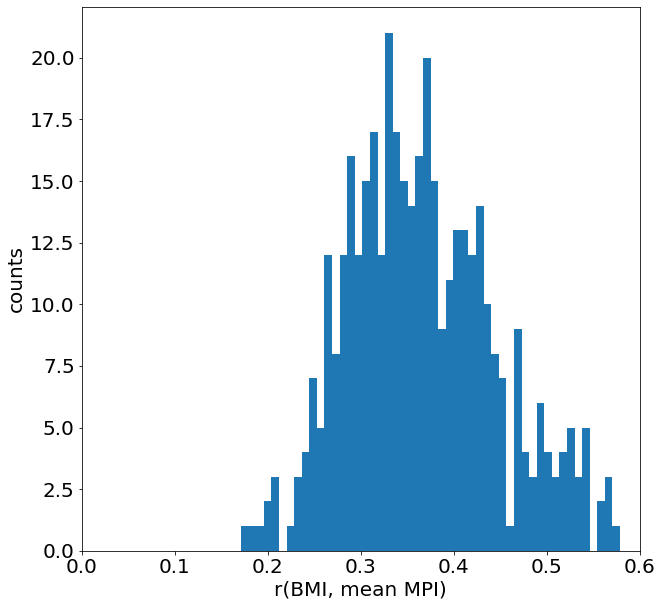

In [96]:
plt.hist(r_meanMPI_BMI, bins=50)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(BMI, mean MPI)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_BMI_meanMPI.png', dpi=300)

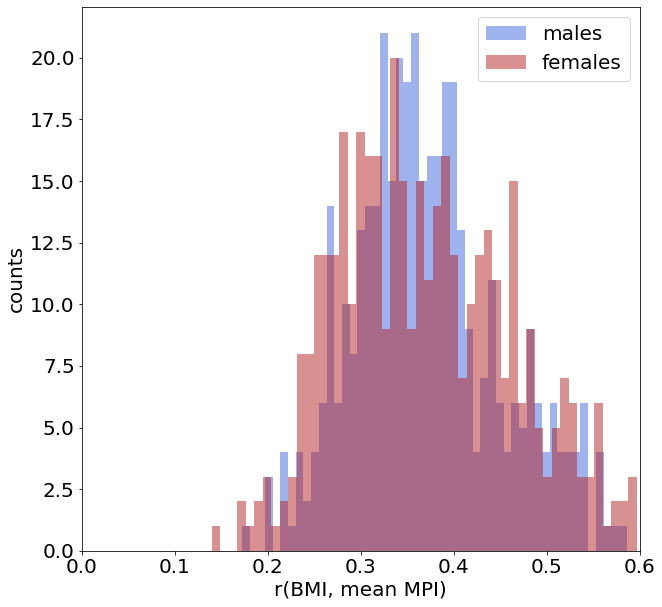

In [98]:
bins = np.linspace(-10, 10, 100)

plt.hist(r_meanMPI_BMI_M, bins = 50, alpha=0.5, color = 'royalblue', label = 'males')
plt.hist(r_meanMPI_BMI_F, bins = 50, alpha=0.5, color = 'firebrick', label = 'females')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(BMI, mean MPI)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize = 20)
plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_BMI_meanMPI_bysex.png', dpi=300)

### Histograms correlation coefficients r(ICV, mean_MPI)

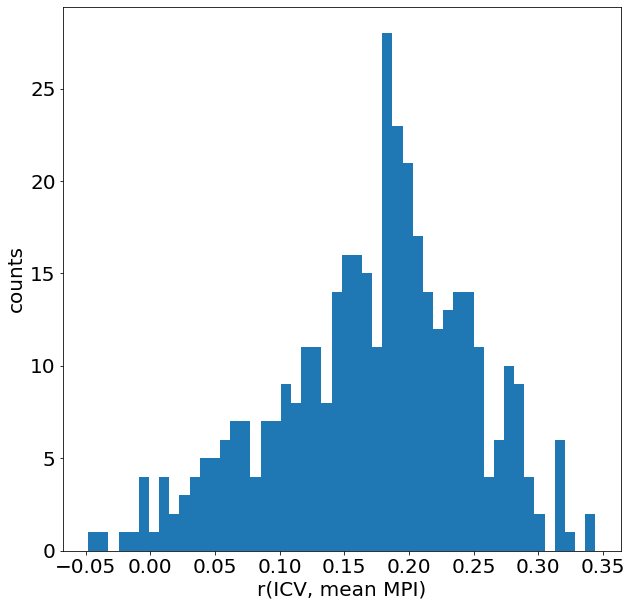

In [110]:
plt.hist(r_meanMPI_ICV, bins=50)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(ICV, mean MPI)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_ICV_meanMPI.png', dpi=300)

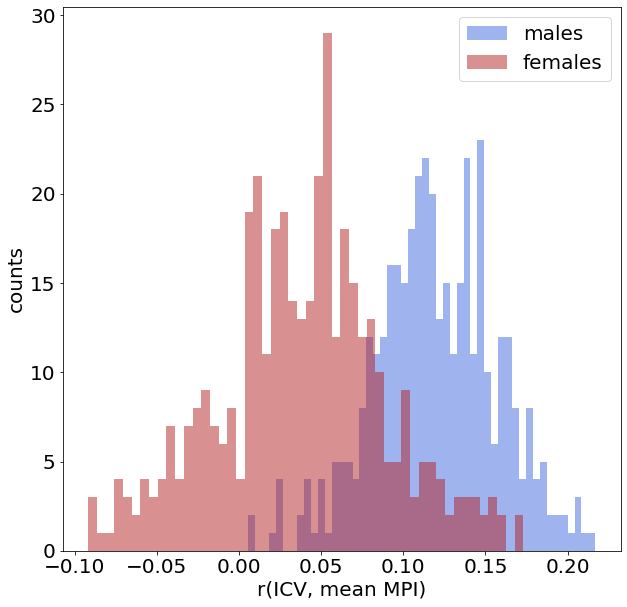

In [111]:
bins = np.linspace(-10, 10, 100)

plt.hist(r_meanMPI_ICV_M, bins = 50, alpha=0.5, color = 'royalblue', label = 'males')
plt.hist(r_meanMPI_ICV_F, bins = 50, alpha=0.5, color = 'firebrick', label = 'females')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(ICV, mean MPI)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize = 20)
#plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_ICV_meanMPI_bysex.png', dpi=300)

the greater correlations for males simply reflects head size:

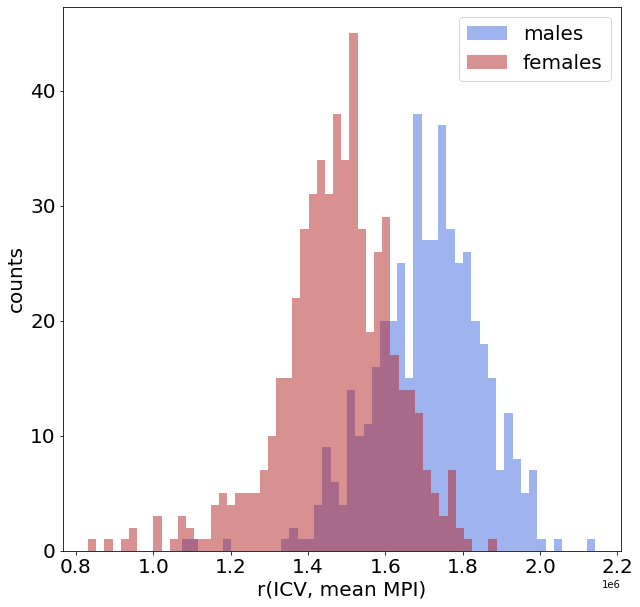

In [119]:
bins = np.linspace(-10, 10, 100)

plt.hist(HCP_demographics_cleaned_withMPC_M.FS_IntraCranial_Vol, bins = 50, alpha=0.5, color = 'royalblue', label = 'males')
plt.hist(HCP_demographics_cleaned_withMPC_F.FS_IntraCranial_Vol, bins = 50, alpha=0.5, color = 'firebrick', label = 'females')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(ICV, mean MPI)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize = 20)
#plt.xlim([0, 0.6])

## Correlation between BMI / ICV and MPC G1 values per parcel

In [113]:
r_MPC_BMI = []
r_MPC_BMI_M = []
r_MPC_BMI_F = []

for i in range(400):
    r_MPC_BMI.append(stats.pearsonr(HCP_BMI_rm_faulty, HCP_array_aligned_mpc_G1_rm_faulty_BMI.T[i])[0])
    r_MPC_BMI_M.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_M.BMI, HCP_array_aligned_mpc_G1_M.T[i])[0])
    r_MPC_BMI_F.append(stats.pearsonr(HCP_BMI_rm_faulty_F, HCP_array_aligned_mpc_G1_rm_faulty_BMI_F.T[i])[0])


In [114]:
r_MPC_ICV = []
r_MPC_ICV_M = []
r_MPC_ICV_F = []

for i in range(400):
    r_MPC_ICV.append(stats.pearsonr(HCP_demographics_cleaned_withMPC.FS_IntraCranial_Vol, HCP_array_aligned_mpc_G1.T[i])[0])
    r_MPC_ICV_M.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_M.FS_IntraCranial_Vol, HCP_array_aligned_mpc_G1_M.T[i])[0])
    r_MPC_ICV_F.append(stats.pearsonr(HCP_demographics_cleaned_withMPC_F.FS_IntraCranial_Vol, HCP_array_aligned_mpc_G1_F.T[i])[0])

### Histograms correlation coefficients r(BMI, MPC_G1)

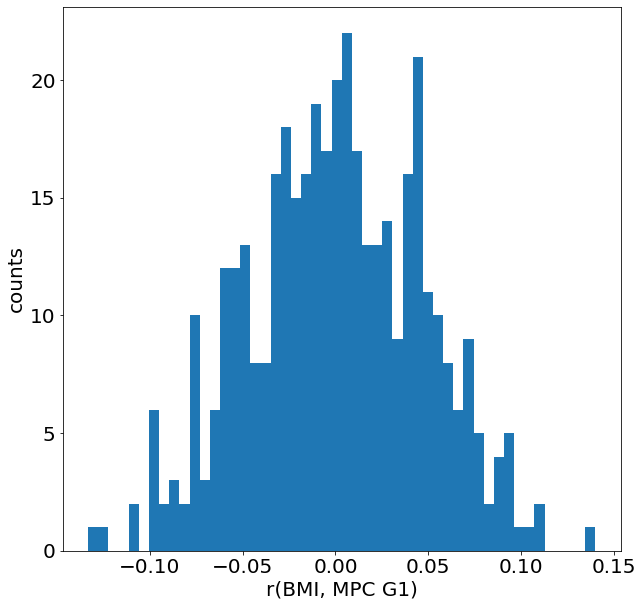

In [99]:
plt.hist(r_MPC_BMI, bins=50)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(BMI, MPC G1)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_BMI_MPC.png', dpi=300)

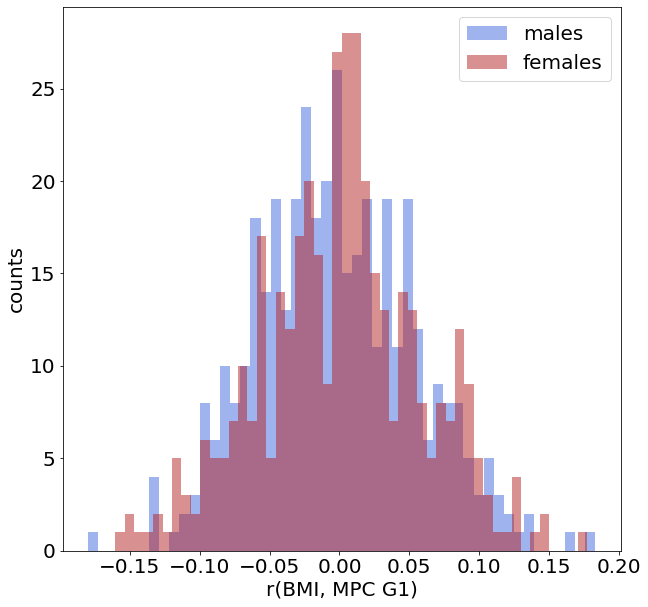

In [100]:
bins = np.linspace(-10, 10, 100)

plt.hist(r_MPC_BMI_M, bins = 50, alpha=0.5, color = 'royalblue', label = 'males')
plt.hist(r_MPC_BMI_F, bins = 50, alpha=0.5, color = 'firebrick', label = 'females')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(BMI, MPC G1)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize = 20)

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_BMI_MPC_bysex.png', dpi=300)

### Histograms correlation coefficients r(ICV, MPC_G1)

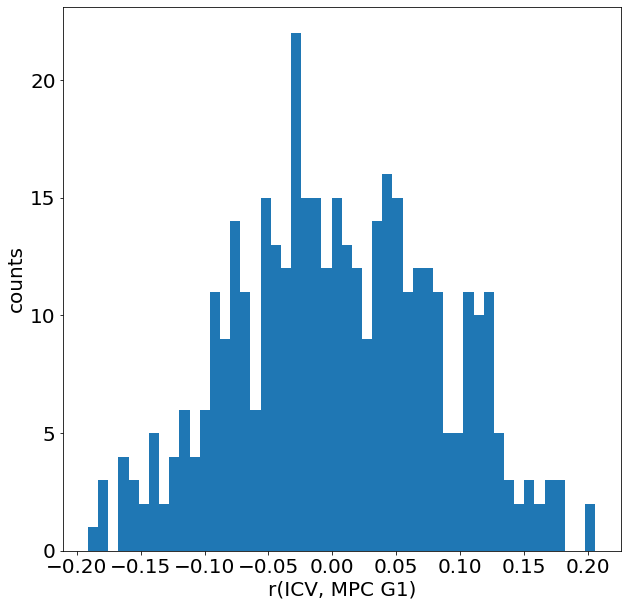

In [116]:
plt.hist(r_MPC_ICV, bins=50)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(ICV, MPC G1)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_ICV_MPC.png', dpi=300)

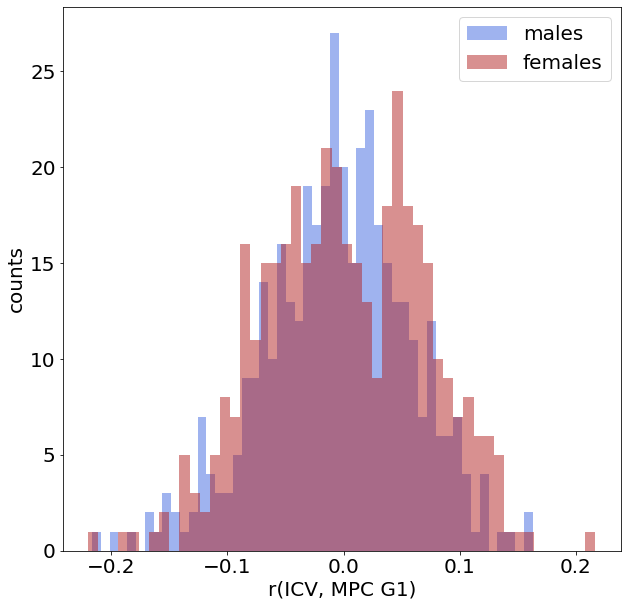

In [117]:
bins = np.linspace(-10, 10, 100)

plt.hist(r_MPC_ICV_M, bins = 50, alpha=0.5, color = 'royalblue', label = 'males')
plt.hist(r_MPC_ICV_F, bins = 50, alpha=0.5, color = 'firebrick', label = 'females')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("r(ICV, MPC G1)", size = 20)
plt.ylabel("counts", size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize = 20)
#plt.xlim([0, 0.6])

plt.savefig(resdir_suppl+'t1wt2w_field_bias_check_hist_corr_ICV_MPC_bysex.png', dpi=300)

### Histograms with gaussian curve (although not sure it's correct)

In [189]:
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
    
#x = np.random.normal(10, 5, size=10000)

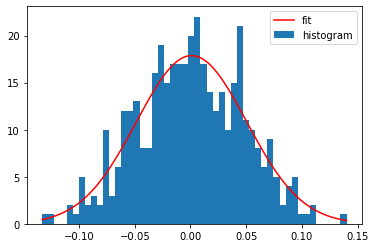

In [194]:
bin_heights, bin_borders = np.histogram(r_MPC_BMI, bins=50)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

plt.bar(bin_centers, bin_heights, width=bin_widths, label='histogram')
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='red')
plt.legend()

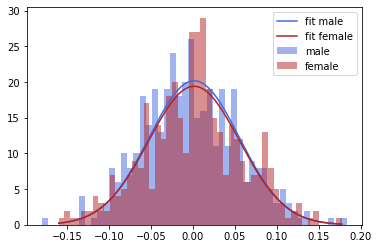

In [196]:
bin_heights_M, bin_borders_M = np.histogram(r_MPC_BMI_M, bins=50)
bin_widths_M = np.diff(bin_borders_M)
bin_centers_M = bin_borders_M[:-1] + bin_widths_M / 2
popt_M, _ = curve_fit(gaussian, bin_centers_M, bin_heights_M, p0=[1., 0., 1.])

bin_heights_F, bin_borders_F = np.histogram(r_MPC_BMI_F, bins=50)
bin_widths_F = np.diff(bin_borders_F)
bin_centers_F = bin_borders_F[:-1] + bin_widths_F / 2
popt_F, _ = curve_fit(gaussian, bin_centers_F, bin_heights_F, p0=[1., 0., 1.])

x_interval_for_fit_M = np.linspace(bin_borders_M[0], bin_borders_M[-1], 10000)
x_interval_for_fit_F = np.linspace(bin_borders_F[0], bin_borders_F[-1], 10000)

plt.bar(bin_centers_M, bin_heights_M, width=bin_widths_M, label='male', alpha=0.5, color = 'royalblue')
plt.bar(bin_centers_F, bin_heights_F, width=bin_widths_F, label='female', alpha=0.5, color = 'firebrick')

plt.plot(x_interval_for_fit_F, gaussian(x_interval_for_fit_M, *popt_M), label='fit male', c='royalblue')
plt.plot(x_interval_for_fit_F, gaussian(x_interval_for_fit_F, *popt_F), label='fit female', c='firebrick')

plt.legend()